In [2]:
%matplotlib inline

import sys
import os
import shutil
import time
import traceback
from pathlib import Path
import h5py
import json
import pickle
from types import SimpleNamespace


from scipy import signal, stats, spatial, ndimage
from scipy.interpolate import interp1d
from sklearn import linear_model as lm


import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Utils.filter_functions as filter_funcs 
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp_funcs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs


from importlib import reload
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [83]:
subject_id = 'Li'
session = 'Li_OF_060718'
#subject_info = SubjectInfo(subject_id, overwrite=True)
subject_info = SubjectInfo(subject_id)
session_info = SubjectSessionInfo(subject_id,session)
track_params = SimpleNamespace(**session_info.task_params)

n_units = session_info.n_units
print(session_info)
session_info.print_task_params()


number of units in session 37

Session Information for subject Li, session Li_OF_060718
Number of curated units: 37
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> time. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> spike_maps. Executed = True
  -> fr_maps. Executed = True
  -> scores. Executed = False
  -> lnp_scores. Executed = False

To run all analyses use run_analyses().


Task/track and analysis parameters. 

  -> time_step: 0.02
  -> x_pix_lims: [100, 650]
  -> y_pix_lims: [100, 500]
  -> x_pix_bias: -380
  -> y_pix_bias: -280
  -> vt_rate: 0.016666666666666666
  -> xy_pix_rot_rad: 1.6507963267948966
  -> x_pix_mm: 3.7790697674418605
  -> y_pix_mm: 3.265765765765766
  -> x_mm_bias: 20
  -> y_mm_bias: 650
  -> x_mm_lims: [-630, 630]
  -> y_mm_lims: [-60, 1350]
  -> x_cm_lims: [-63, 63]
  -> y_cm_lims: [-6, 135]
  -> mm_bin: 30
  -> cm_bin: 3
  -> max_

### Load data

In [85]:
spks,_,_ = session_info.get_spikes()
binned_spks = session_info.get_binned_spikes()
fr = session_info.get_fr()
t_rs = session_info.get_time()
of_dat = session_info.get_track_data() 
of_dat = SimpleNamespace(**of_dat)
spike_maps = session_info.get_spike_maps()
fr_maps = session_info.get_fr_maps(overwrite=True)

Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


In [86]:
def plot_map(map_):
    f, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    ax.axis('off')
    return f,ax
    
def plot_unit_map(unit, maps_):
    return plot_map(maps_[unit])
    

_=interact(plot_unit_map, unit=widgets.IntSlider(min=0, max=n_units-1, step=1, value=0), maps_=fixed(fr_maps))


interactive(children=(IntSlider(value=0, description='unit', max=36), Output()), _dom_classes=('widget-interac…

# Development of Solstad Border Score
The border score is defined as:

$$ b = \frac{c_m - d_m}{c_m + d_m} $$

where $c_m$ corresponds to the maximum border coverage of a given field, and $d_m$ is the linearly distance weighted firing rate to the center.

Text(0.5, 1.0, 'Thresholded map')

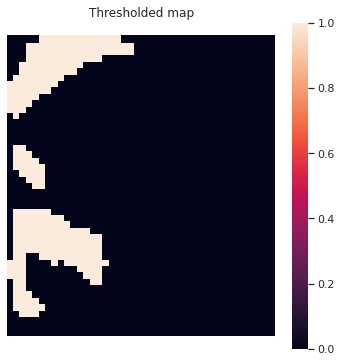

In [87]:
unit = 10
fr_thr = 0.25

fr_map = fr_maps[unit]
max_fr = fr_map.max()
thr_map = fr_map>=fr_thr*max_fr
f,ax=plot_map(thr_map)
ax.set_title('Thresholded map')

#### basic image processing

Text(0.5, 1.0, 'Thresholded map')

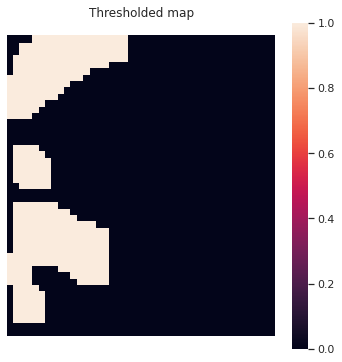

In [88]:
thr_map = fr_map>=fr_thr*max_fr
border_mask = np.ones_like(fr_map, dtype=bool)
border_mask[[0,-1],:] = False
border_mask[:,[0,-1]] = False

# eliminates small
thr_map2=ndimage.binary_opening(thr_map,structure=np.ones((3,3)))
thr_map2=ndimage.binary_closing(thr_map2,structure=np.ones((3,3)), mask=border_mask)
thr_map3=ndimage.binary_dilation(thr_map2,structure=np.ones((3,3)))

_, ax= plot_map(thr_map3)
ax.set_title('Thresholded map')

Text(0.5, 1.0, ' Field IDs ')

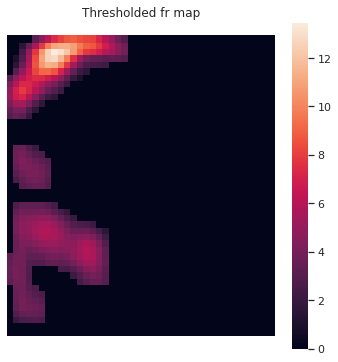

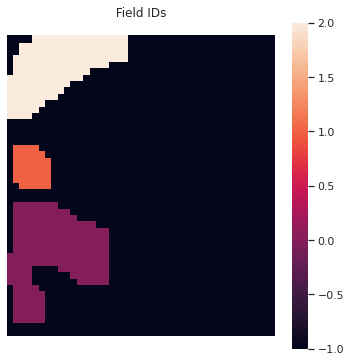

In [89]:
# get field ids
fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

#check for small fields
field_sizes_cm2 = np.zeros(n_fields)
bin_cm2 =track_params.cm_bin**2
for f in range(n_fields):
    field_sizes_cm2[f] = (np.sum(fields_map==f)*bin_cm2)
    
min_field_size_cm2 = 200
if np.any(field_sizes_cm2<min_field_size_cm2):
    small_fields = np.where(field_sizes_cm2<min_field_size_cm2)[0]
    for f in small_fields:
        thr_map3[fields_map==f] = 0
    fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

fields_map-=1 # zero-center
f, ax = plot_map(fr_map*(fields_map>=0))
ax.set_title('Thresholded fr map')

f,ax = plot_map(fields_map)
ax.set_title(' Field IDs ')

### get border mask

Text(0.5, 1.0, ' border markers ')

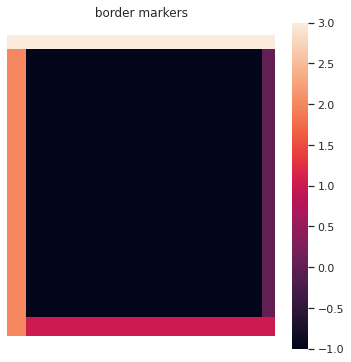

In [90]:
border_width = track_params.border_width_bins  
map_height, map_width = fr_map.shape # in bins
border_wide_mask = np.ones_like(fr_map, dtype=int)*-1
border_wide_mask[:, map_width:(map_width-border_width):-1] = 0 # right / East
border_wide_mask[0:border_width,:] = 1 # top / North
border_wide_mask[:, 0:border_width] = 2 # left / West
border_wide_mask[map_height:(map_height-border_width):-1,:] = 3 # bottom / Sout

f,ax = plot_map(border_wide_mask)
ax.set_title(' border markers ')

### get linear distance to closest wall

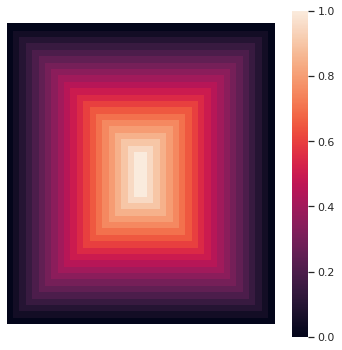

In [91]:
distance_mat = spatial_funcs.get_center_border_distance_mat(map_height,map_width)
f,ax = plot_map(distance_mat)

### get max border coverage

In [92]:
wall_coverage = np.zeros((n_fields, 4))
wall_labels_mask = spatial_funcs.get_wall_masks(map_height, map_width, border_width)

for field in range(n_fields):
    for wall in range(4):
        wall_coverage[field, wall] = \
        np.sum((fields_map == field) * (wall_labels_mask[wall] == wall)) \
        / np.sum(wall_labels_mask[wall] == wall)
        
c_m = np.max(wall_coverage)

In [93]:
print(pd.DataFrame(wall_coverage, columns=['E', 'N', 'W', 'S']))
print(f'\n c_m = {c_m:0.3f}')

     E         N         W         S
0  0.0  0.000000  0.304965  0.039683
1  0.0  0.000000  0.092199  0.000000
2  0.0  0.380952  0.205674  0.000000

 c_m = 0.381


### get weighted firing rate

In [94]:
field_fr_map = fr_map * (fields_map >= 0)
d_m = np.sum(field_fr_map * distance_mat) / np.sum(field_fr_map)
print(f' d_m = {d_m:0.3f}')

 d_m = 0.207


### border score

In [95]:
b = (c_m-d_m)/(c_m+d_m)
print(f' b = {b:0.3f}')

 b = 0.296


In [96]:
def get_center_border_distance_mat(h, w):
    """
    creates a pyramid like matrix of distances to border walls.
    :param h: height
    :param w: width
    :return: normalized matrix of distances, center =1, borders=0
    """
    a = np.arange(h)
    b = np.arange(w)

    r_h = np.minimum(a, a[::-1])
    r_w = np.minimum(b, b[::-1])
    pyr = np.minimum.outer(r_h, r_w)
    return pyr / np.max(pyr)


def get_wall_masks(map_height, map_width, wall_width):
    """
    returns a mask for each wall. *assumes [0,0] is on lower left corner.*
    :param map_height:
    :param map_width:
    :param wall_width: size of the border wall
    :return: mask, ndarray size 4 x map_height x map_width, 4 maps each containing a mask for each wall
    """

    mask = np.ones((4, map_height, map_width), dtype=int) * -1

    mask[0][:, map_width:(map_width - wall_width):-1] = 0  # right / East
    mask[1][map_height:(map_height - wall_width):-1, :] = 1  # top / north
    mask[2][:, 0:wall_width] = 2  # left / West
    mask[3][0:wall_width, :] = 3 # bottom / south

    return mask


def get_map_fields(fr_maps, fr_thr=0.3, min_field_size=20, filt_structure=None):
    """
    gets labeled firing rate maps. works on either single maps or an array of maps.
    returns an array of the same dimensions as fr_maps with
    :param fr_maps: np.ndarray, (dimensions can be 2 or 3), if 3 dimensions, first dimensions must
                    correspond to the # of units, other 2 dims are height and width of the map
    :param fr_thr: float, proportion of the max firing rate to threshold the data
    :param min_field_size: int, # of bins that correspond to the total area of the field. fields found
                    under this threshold are discarded
    :param filt_structure: 3x3 array of connectivity. see ndimage for details
    :return field_labels (same dimensions as input), -1 values are background, each field has an int label

    -> code based of the description on Solstad et al, Science 2008
    """
    if filt_structure is None:
        filt_structure = np.ones((3, 3))

    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis, :, :]
    elif fr_maps.ndim == 1:
        print('fr_maps is a one dimensional variable.')
        return None

    n_units, map_height, map_width = fr_maps.shape

    # create border mask to avoid elimating samples during the image processing step
    border_mask = np.ones((map_height, map_width), dtype=bool)
    border_mask[[0, -1], :] = False
    border_mask[:, [0, -1]] = False

    # determine thresholds
    max_fr = fr_maps.max(axis=1).max(axis=1)

    # get fields
    field_maps = np.zeros_like(fr_maps)
    n_fields = np.zeros(n_units, dtype=int)
    for unit in range(n_units):
        # threshold the maps
        thr_map = fr_maps[unit] >= max_fr[unit] * fr_thr

        # eliminates small/noisy fields, fills in gaps
        thr_map = ndimage.binary_closing(thr_map, structure=filt_structure, mask=border_mask)
        thr_map = ndimage.binary_dilation(thr_map, structure=filt_structure)

        # get fields ids
        field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)

        # get the area of the fields in bins
        field_sizes = np.zeros(n_fields_unit)
        for f in range(n_fields_unit):
            field_sizes[f] = np.sum(field_map == f)

        # check for small fields and re-do field identification if necessary
        if np.any(field_sizes < min_field_size):
            small_fields = np.where(field_sizes < min_field_size)[0]
            for f in small_fields:
                thr_map[field_map == f] = 0
            field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)

        # store
        field_maps[unit] = field_map
        n_fields[unit] = n_fields_unit

    field_maps -= 1  # make background -1, labels start at zero

    # if only one unit, squeeze to match input dimensions
    if n_units == 1:
        field_maps = field_maps.squeeze()

    return field_maps, n_fields


def get_border_scores(fr_maps, fr_thr, min_field_size_bin, wall_width_bin):
    """
    Border score method from Solstad et al Science 2008. Returns the border score along with the max coverage by a field
    and the weighted firing rate. This works for a single fr_map or multiple.
    :param fr_maps: np.ndarray, (dimensions can be 2 or 3), if 3 dimensions, first dimensions must
                    correspond to the # of units, other 2 dims are height and width of the map
    :param fr_thr: float, proportion of the max firing rate to threshold the data
    :param min_field_size_bin: int, # of bins that correspond to the total area of the field. fields found
                    under this threshold are discarded
    :param wall_width_bin: wall width by which the coverage is determined.
    :return: border score, max coverage, distanced weighted fr for each unit in fr_maps.

    -> code based of the description on Solstad et al, Science 2008
    """
    n_walls = 4
    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis, ]
    n_units, map_height, map_width = fr_maps.shape

    # get fields
    field_maps, n_fields = get_map_fields(fr_maps, fr_thr=fr_thr, min_field_size=min_field_size_bin)

    if field_maps.ndim == 2:
        field_maps = field_maps[np.newaxis, ]

    # get border distance matrix
    distance_mat = get_center_border_distance_mat(map_height, map_width)  # linear distance to closest wall [bins]

    # get wall labels
    wall_labels_mask = get_wall_masks(map_height, map_width, wall_width_bin)

    # pre-allocate scores
    border_score = np.zeros(n_units) * np.nan
    max_coverage = np.zeros(n_units) * np.nan
    weighted_fr = np.zeros(n_units) * np.nan

    # loop and get scores
    for unit in range(n_units):
        fr_map = fr_maps[unit]
        field_map = field_maps[unit]
        n_fields_unit = n_fields[unit]
        if n_fields_unit > 0:
            # get coverage
            wall_coverage = np.zeros((n_fields_unit, n_walls))
            for field in range(n_fields_unit):
                for wall in range(n_walls):
                    wall_coverage[field, wall] = np.sum(
                        (field_map == field) * (wall_labels_mask[wall] == wall)) / np.sum(
                        wall_labels_mask[wall] == wall)
            c_m = np.max(wall_coverage)

            # get normalized distanced weighted firing rate
            field_fr_map = fr_map * (field_map >= 0)
            d_m = np.sum(field_fr_map * distance_mat) / np.sum(field_fr_map)

            # get border score
            b = (c_m - d_m) / (c_m + d_m)

            border_score[unit] = b
            max_coverage[unit] = c_m
            weighted_fr[unit] = d_m

    return border_score, max_coverage, weighted_fr


In [97]:
out = spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, track_params.x_bin_edges_, track_params.y_bin_edges_)

In [98]:
out[0]

,solstad_score,solstad_sig,aR2,rmse,nrmse
0,0.364803,1.0,0.003837,5.030571,2.199636
1,0.419546,1.0,0.017009,11.583824,0.936995
2,0.424479,1.0,0.024745,10.782260,1.034362
3,0.409651,1.0,0.038320,6.595632,1.067205
4,0.405837,1.0,0.016980,24.574617,0.749446
5,0.468619,0.0,0.022536,6.960973,1.823718
6,0.494666,0.0,0.013591,6.821572,1.945194
7,0.386649,1.0,0.001496,4.930943,2.207164
8,0.444261,0.0,0.003278,8.023617,1.726517
9,0.419920,1.0,0.004717,8.479417,1.257281


In [48]:
border_model_coeff = pd.DataFrame(out[1], columns=['bias', 'East', 'North', 'Center'])
border_model_coeff.loc[unit]

bias      1.528328
East     -0.363710
North     0.469864
Center   -0.735573
Name: 11, dtype: float64

### test border score method

In [99]:

def test_border_score():

    height=50
    width=40
    
    n_tests = np.zeros(8)
    dummy_mat = np.zeros((8, height, width))
    
    #print('Border Score for an east single wall') 
    dummy_mat[0][:,-1]=1 # 
    
    #print('Border Score for a north single wall')
    dummy_mat[1][0,:]=1 # 
    
    #print('Border Score for a west single wall')
    dummy_mat[2][:,0]=1 # 
    
    #print('Border Score for a south single wall')
    dummy_mat[3][-1,:]=1 # 
    
    #print('Border Score for center region')
    dummy_mat[4][(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
    
    #print('Border Score for thick wall')
    dummy_mat[5][0:5,:]=1
    
    #print('Border Score for full coverage')
    dummy_mat[6] = np.ones((height, width))
    
    #print('Border Score for full coverage')
    dummy_mat[7][:,-1]=1
    dummy_mat[7][-1,:]=1
    dummy_mat[7][:,0]=1
    dummy_mat[7][0,:]=1
    
    b,_=spatial_funcs.get_border_score_solstad(dummy_mat)
    
    return b, dummy_mat


b, dummy_mat = test_border_score()

def plot_test_map(test_num):
    print(f'Border Score = {b[test_num]:0.3f}')

    f, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(dummy_mat[test_num], ax=ax, cmap='Greys' )
    ax.invert_yaxis()
    ax.axis('equal')
    return f,ax
    
_=interact(plot_test_map, test_num=widgets.IntSlider(min=0, max=len(b)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='test_num', max=7), Output()), _dom_classes=('widget-inte…

# develop glm version

Text(0.5, 1.0, 'Distance to Center from a Wall')

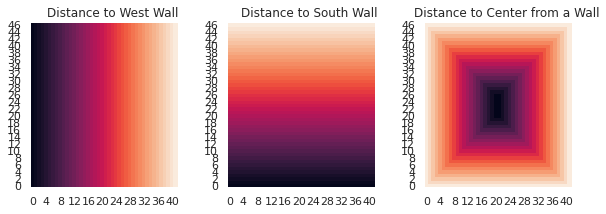

In [100]:
# in this implementation west dist represents the distance to the west wall,
# however, this is counter intuitive as a positive relationship would mean east coding

height, width = fr_maps.shape[1:]
spatial_funcs = reload(spatial_funcs)
west_dist = np.tile(np.arange(width),height).reshape(height,width)
west_dist = west_dist/ np.max(west_dist)

south_dist = np.repeat(np.arange(height),width).reshape(height,width)
south_dist = south_dist/ np.max(south_dist)

wall_center_dist = 1-spatial_funcs.get_center_border_distance_mat(height,width)

f,ax=plt.subplots(1,3, figsize=(10,6))
sns.heatmap(west_dist,ax=ax[0],cbar=False)
ax[0].invert_yaxis()
ax[0].axis('square')
ax[0].set_title('Distance to West Wall')

sns.heatmap(south_dist,ax=ax[1],cbar=False)
ax[1].invert_yaxis()
ax[1].axis('square')
ax[1].set_title('Distance to South Wall')

sns.heatmap(wall_center_dist,ax=ax[2],cbar=False)
ax[2].invert_yaxis()
ax[2].axis('square')
ax[2].set_title('Distance to Center from a Wall')

another implementation is not to call it distance, but proximity. and not use a linear scale. we use a sigmoid function to estimate the value near a wall. The critical implementation detail is the slope of the sigmoid such that at some distance 'wall_width' the values saturate. We do this with a combination of analytical and numerical approaches.

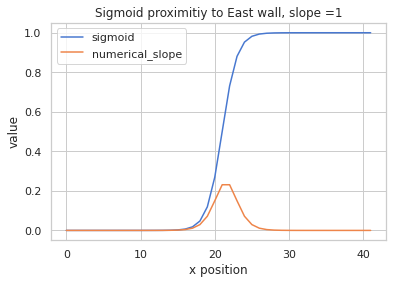

In [54]:
def sigmoid(x, center, slope):
    return 1./(1+np.exp(-slope*(x-center)))

x=np.arange(width)
slope = 1
z = sigmoid(x,width/2,slope)
plt.plot(x,z, label='sigmoid')
plt.plot(np.append(0,np.diff(z)), label = 'numerical_slope')
plt.xlabel('x position')
plt.ylabel('value')
plt.title(f'Sigmoid proximitiy to East wall, slope ={slope}')
plt.legend()

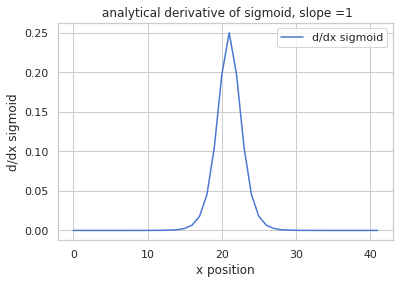

In [55]:
def d_sigmoid(x, center, slope):
    u = np.exp(-slope*(x-center))
    return slope*u/(1+u)**2

plt.plot(x,d_sigmoid(x,width/2,1),label='d/dx sigmoid')
plt.xlabel('x position')
plt.ylabel('d/dx sigmoid')
plt.title(f' analytical derivative of sigmoid, slope ={slope}')
plt.legend()

Text(0.5, 1.0, 'optimal slope vs wall width')

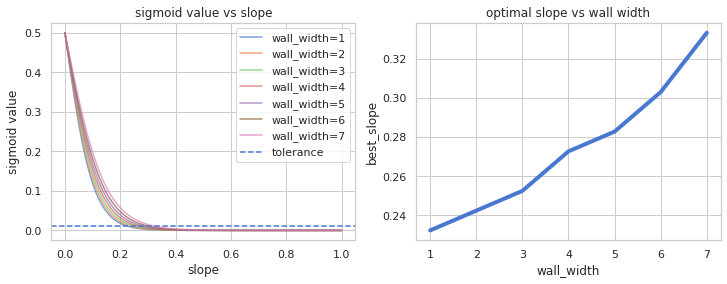

In [56]:
# find slopes for different wall widths, using sigmoid
max_width = 8
wall_widths = np.arange(1,max_width)
slopes = np.linspace(0,1,100)
tolerance = 0.01 # acccepted value of sigmoid at the wall value
best_slopes = np.zeros(max_width-1)

f, ax = plt.subplots(1,2, figsize=(12,4))
for ii, wall_width in enumerate(wall_widths):
    z = sigmoid(wall_width,width/2,slopes)
    #best_slopes[ii] = slopes[np.argmin(np.abs(z-tolerance))]
    best_slopes[ii] = slopes[np.argmin((z-tolerance)**2)]
    ax[0].plot(slopes,z, alpha=0.7, label=f'wall_width={wall_width}')
ax[0].axhline(tolerance,linestyle='--', label = 'tolerance')
ax[0].legend()
ax[0].set_xlabel('slope')
ax[0].set_ylabel('sigmoid value')
ax[0].set_title('sigmoid value vs slope')

ax[1].plot(wall_widths, best_slopes,linewidth=4)
ax[1].set_xlabel('wall_width')
ax[1].set_ylabel('best_slope')
ax[1].set_title('optimal slope vs wall width')

In [57]:
def find_optimum_sigmoid_slope(wall_width, dimension_length, goal=0.01):
    x = np.arange(dimension_length)
    slopes = np.linspace(0,2,200)
    z = sigmoid(wall_width,dimension_length/2,slopes)
    return slopes[np.argmin((z-goal)**2)]
    
wall_width = 3
slope_x = find_optimum_sigmoid_slope(wall_width, width) 
slope_y = find_optimum_sigmoid_slope(wall_width, height) 
print(slope_x, slope_y)

0.25125628140703515 0.22110552763819097


use gaussian to get proximity to center

(0.0, 42.0, 0.0, 47.0)

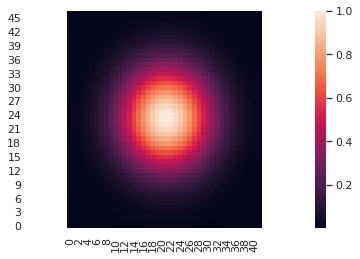

In [58]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x, y = np.meshgrid(np.arange(width),np.arange(height)) # get 2D variables instead of 1D
center_prox = gaus2d(y=y, x=x, my=height/2, mx=width/2, sx=width/6, sy=height/6)
center_prox = center_prox/np.max(center_prox)
ax=sns.heatmap(center_prox)
ax.invert_yaxis()
ax.axis('equal')


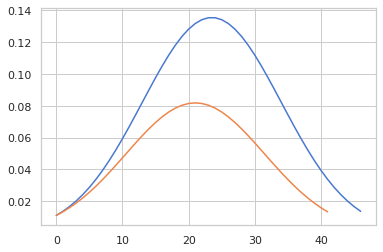

In [24]:
plt.plot(center_prox[:,0])
plt.plot(center_prox[0,:])

Text(0.5, 1.0, 'Proximity to Center')

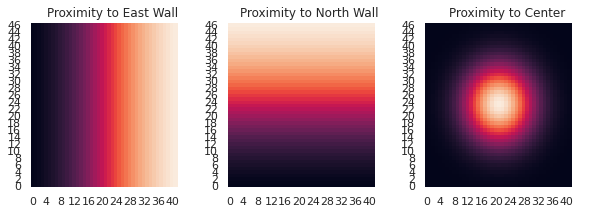

In [63]:
wall_width = 3
sigmoid_slope_w = find_optimum_sigmoid_slope(wall_width, width, goal=0.1) 
sigmoid_slope_h = find_optimum_sigmoid_slope(wall_width, height, goal=0.1) 
center_w = width/2
center_h = height/2

east_prox = np.tile(sigmoid(np.arange(width), width/2, sigmoid_slope_w),height).reshape(height,width)
north_prox = np.repeat(sigmoid(np.arange(height), height/2, sigmoid_slope_h),width).reshape(height,width)

f,ax=plt.subplots(1,3, figsize=(10,6))
sns.heatmap(east_prox,ax=ax[0],cbar=False)
ax[0].invert_yaxis()
ax[0].axis('square')
ax[0].set_title('Proximity to East Wall')

sns.heatmap(north_prox,ax=ax[1],cbar=False)
ax[1].invert_yaxis()
ax[1].axis('square')
ax[1].set_title('Proximity to North Wall')

sns.heatmap(center_prox,ax=ax[2],cbar=False)
ax[2].invert_yaxis()
ax[2].axis('square')
ax[2].set_title('Proximity to Center')

for each x,y position get a 3 feature vector reflecting the distance to the north wall, west wall and center

In [70]:
_,x_bin_idx,=rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
_,y_bin_idx,=rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)

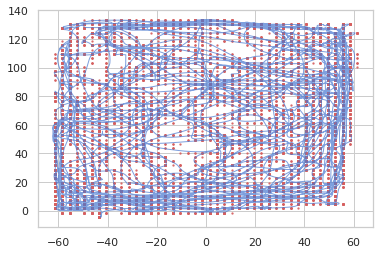

In [77]:
plt.plot(of_dat.x, of_dat.y, alpha=0.7, linewidth=1)
plt.scatter(track_params.x_bin_centers_[x_bin_idx],track_params.y_bin_centers_[y_bin_idx], s=2, alpha=0.75, color='r')

(array([3.12645482, 4.58154499, 3.08331198, 1.88763912, 1.36264124,
        0.81355061, 1.04999576, 0.74463413, 0.59839673, 0.46280496,
        0.4891389 , 0.38884581, 0.30143955, 0.31600726, 0.19050083,
        0.20562884, 0.21459358, 0.11934317, 0.17761401, 0.10981813]),
 array([0.01107128, 0.06051771, 0.10996415, 0.15941058, 0.20885702,
        0.25830346, 0.30774989, 0.35719633, 0.40664277, 0.4560892 ,
        0.50553564, 0.55498207, 0.60442851, 0.65387495, 0.70332138,
        0.75276782, 0.80221426, 0.85166069, 0.90110713, 0.95055356,
        1.        ]),
 <a list of 20 Patch objects>)

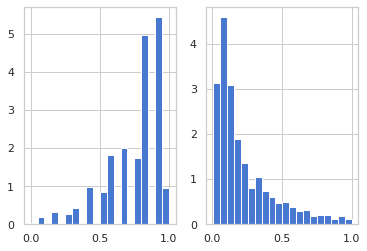

In [29]:
f,ax = plt.subplots(1,2)
ax[0].hist(wall_center_dist[y_bin_idx,x_bin_idx], 20, density=True)
ax[1].hist(center_prox[y_bin_idx,x_bin_idx], 20, density=True )

(array([3.60570117, 1.56662739, 1.24227017, 0.64092028, 0.45386029,
        0.2913819 , 0.64391803, 0.36452715, 0.90652148, 0.54199432,
        0.42508183, 0.80100046, 0.39330561, 0.31716261, 0.65770771,
        0.65770771, 0.79380584, 0.84776546, 2.12301095, 4.36653169]),
 array([0.03534776, 0.08155677, 0.12776578, 0.17397478, 0.22018379,
        0.2663928 , 0.31260181, 0.35881082, 0.40501982, 0.45122883,
        0.49743784, 0.54364685, 0.58985586, 0.63606487, 0.68227387,
        0.72848288, 0.77469189, 0.8209009 , 0.86710991, 0.91331892,
        0.95952792]),
 <a list of 20 Patch objects>)

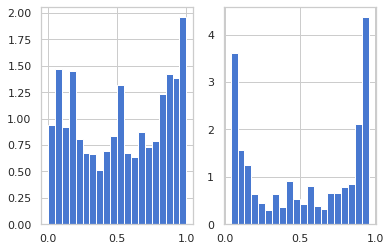

In [30]:
f,ax = plt.subplots(1,2)
ax[0].hist(south_dist[y_bin_idx,x_bin_idx], 20, density=True)
ax[1].hist(north_prox[y_bin_idx,x_bin_idx], 20, density=True )

(array([4.10075159, 1.67587112, 1.59888132, 0.68514959, 0.23992172,
        0.57294739, 0.30318466, 0.26379453, 0.23216306, 0.23156624,
        0.54609048, 0.27632775, 0.30079738, 0.37360945, 0.50789399,
        0.27513411, 0.7179747 , 0.89403666, 2.27269132, 5.47343805]),
 array([0.03302575, 0.07944621, 0.12586667, 0.17228713, 0.21870759,
        0.26512805, 0.31154851, 0.35796897, 0.40438943, 0.45080989,
        0.49723035, 0.54365081, 0.59007127, 0.63649173, 0.68291219,
        0.72933265, 0.77575311, 0.82217357, 0.86859403, 0.91501449,
        0.96143495]),
 <a list of 20 Patch objects>)

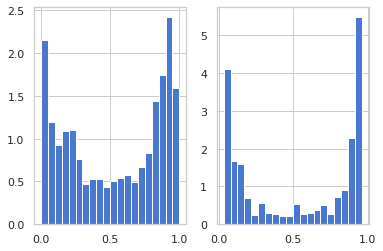

In [31]:
f,ax = plt.subplots(1,2)
ax[0].hist(west_dist[y_bin_idx,x_bin_idx], 20, density=True)
ax[1].hist(east_prox[y_bin_idx,x_bin_idx], 20, density=True )

In [78]:
wd = west_dist[y_bin_idx,x_bin_idx]
sd = south_dist[y_bin_idx,x_bin_idx]
cd = wall_center_dist[y_bin_idx,x_bin_idx]

X_lin = np.column_stack((np.ones_like(wd), wd, sd, cd))
model_lin = lm.LinearRegression(fit_intercept=False).fit(X_lin, fr.T)
fr_hat_lin = model_lin.predict(X_lin).T

ep = east_prox[y_bin_idx,x_bin_idx]
north_p = north_prox[y_bin_idx, x_bin_idx]
cp = center_prox[y_bin_idx, x_bin_idx]

X_sm = np.column_stack((np.ones_like(ep), ep, north_p, cp))
model_sm = lm.LinearRegression(fit_intercept=False).fit(X_sm, fr.T)
fr_hat_sm = model_sm.predict(X_sm).T
# model_coef[unit] = model.coef_

In [79]:
ar2_lin = rs.get_ar2(fr, fr_hat_lin, 3)
ar2_sm = rs.get_ar2(fr, fr_hat_sm, 3)

rmse_lin = rs.get_rmse(fr, fr_hat_lin)
rmse_sm = rs.get_rmse(fr, fr_hat_sm)

nrmse_lin = rs.get_nrmse(fr, fr_hat_lin)
nrmse_sm = rs.get_nrmse(fr, fr_hat_sm)

Text(0.5, 1.0, 'Border Score vs aR2')

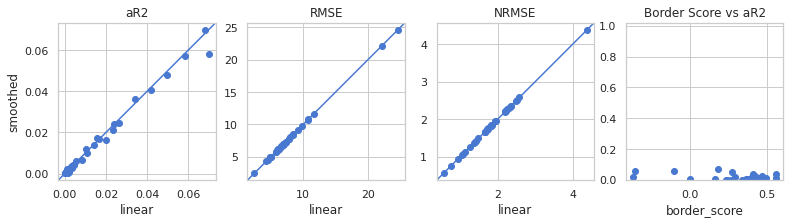

In [82]:
f,ax=plt.subplots(1,4, figsize=(13,6))
ax[0].scatter(ar2_lin,ar2_sm)
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].axis('square')
ax[0].set_xlabel('linear')
ax[0].set_ylabel('smoothed')
ax[0].set_title('aR2')

ax[1].scatter(rmse_lin,rmse_sm)
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].axis('square')
ax[1].set_xlabel('linear')
ax[1].set_title('RMSE')

ax[2].scatter(nrmse_lin,nrmse_sm)
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].axis('square')
ax[2].set_xlabel('linear')
ax[2].set_title('NRMSE')

ax[3].scatter(out[0]['solstad_score'],ar2_sm)
#ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[3].axis('square')
ax[3].set_xlabel('border_score')
ax[3].set_title('Border Score vs aR2')

In [181]:
np.argmax(ar2_sm)

4

10


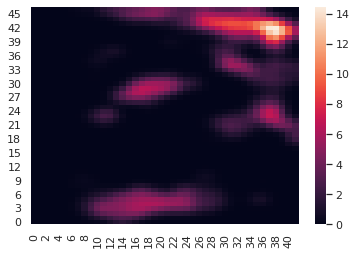

In [182]:
print(np.argmax(border_score))
ax=sns.heatmap(fr_maps[unit])
ax.invert_yaxis()

In [183]:
model_sm.coef_[unit]

array([-1.40730222,  9.32131503,  2.89381838, -3.04513493])

Varianced Explained: 0.11739607553971243


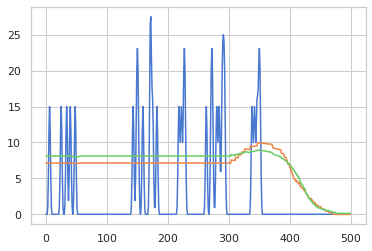

In [184]:
unit = 4
i = 23
w_size = 500
plt.plot(fr[unit][np.arange(w_size)+w_size*i])
plt.plot(fr_hat_lin[unit][np.arange(w_size)+w_size*i])
plt.plot(fr_hat_sm[unit][np.arange(w_size)+w_size*i])
print(f'Varianced Explained: {ar2_sm[unit]}')

(0.0206604933456348, 0.023711290274519126)

Try using poisson regression

In [185]:

model_lin_p = lm.PoissonRegressor(fit_intercept=False, alpha=0).fit(X_lin, binned_spks[unit])
spks_hat_lin_p = model_lin_p.predict(X_lin)

model_sm_p = lm.PoissonRegressor(fit_intercept=False,alpha=0).fit(X_sm, binned_spks[unit])
spks_hat_sm_p = model_sm_p.predict(X_sm).T

null = np.ones_like(binned_spks[unit]).reshape(-1,1)
model_null_p = lm.PoissonRegressor(fit_intercept=False, alpha=0).fit(null, binned_spks[unit])
spks_hat_null_p = model_null_p.predict(null).T

In [186]:
spks_hat_null_p, y.mean()

(array([0.09364618, 0.09364618, 0.09364618, ..., 0.09364618, 0.09364618,
        0.09364618]),
 23.0)

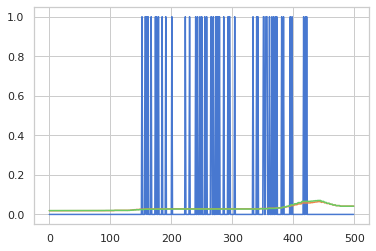

In [187]:
i = 9
w_size = 500
plt.plot(binned_spks[unit][np.arange(w_size)+w_size*i])
plt.plot(spks_hat_lin_p[np.arange(w_size)+w_size*i])
plt.plot(spks_hat_sm_p[np.arange(w_size)+w_size*i])

In [188]:
np.exp(model_lin_p.coef_@X_lin.T)-spks_hat_lin_p

array([0., 0., 0., ..., 0., 0., 0.])

In [189]:
model_sm_p.score(X_sm,binned_spks[unit]), model_lin_p.score(X_lin,binned_spks[unit])

(0.13212020300739868, 0.13568852043858715)

In [97]:
def get_poisson_D2(y, y_hat):
    d = 2*np.sum( (np.log(y**y)-np.log(y_hat**y) - y + y_hat) )
    ym = y.mean()
    d_null = 2*np.sum( (np.log(y**y)-np.log(ym**y) - y + ym) )
    d2 = 1 - d/d_null
    return d2
    
def get_poisson_aD2(y, y_hat, p):
    n = len(y)
    
    d2 = get_poisson_D2(y,y_hat)
    ad2 = 1- (n-1)/(n-p)*(1-d2)
    
    return ad2
    


In [144]:
y = binned_spks[unit]
y_hat = spks_hat_sm_p

d = 2*np.sum( (np.log(y**y)-np.log(y_hat**y) - y + y_hat) )
ym = y.mean()
d_null = 2*np.sum( (np.log(y**y)-np.log(ym**y) - y + ym) )

print(d, d_null)

14303.494912995446 16457.365234375


In [139]:
np.exp(-model_sm_p.coef_[0])

63.79399760860851

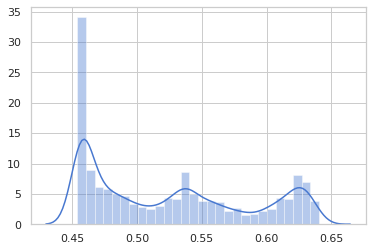

In [140]:
sns.distplot(y_hat)

In [141]:
get_poisson_D2(binned_spks[unit], spks_hat_sm_p), get_poisson_D2(binned_spks[unit], spks_hat_lin_p)

(0.1308757684298517, 0.1356885614084402)

In [190]:
model_sm.coef_[unit], np.exp(-model_sm_p.coef_), border_score[unit]

(array([-1.40730222,  9.32131503,  2.89381838, -3.04513493]),
 array([9.15901812e+01, 6.85975741e-02, 5.11566934e-01, 1.04822677e+00]),
 0.11663999542114767)

In [191]:
print(np.exp(model_sm_p.coef_)-1, np.exp(model_lin_p.coef_)-1 , sep='\n')
print(model_sm.coef_[unit],model_lin.coef_[unit] , sep='\n')



[-0.9890818  13.57777499  0.95477841 -0.04600795]
[-0.99038094 11.7822871   0.80933094  0.31510443]
[-1.40730222  9.32131503  2.89381838 -3.04513493]
[-4.57878541  9.22131293  2.4296127   4.15797939]


In [192]:
model_sm_p.coef_

array([-4.51732407,  2.67949811,  0.67027684, -0.04709994])

In [209]:
def hello(a,**manyargs):
    for k,v in manyargs.items():
        print(k, v)
    print(a)

hello(3, world=1, earth='planet')


d = {'world':1, 'earth':'plaent'}
hello(a=10, **d)

world 1
earth planet
3


NameError: name 'world' is not defined

In [218]:
import statsmodels.api as sm

In [223]:
model = sm.OLS(fr[unit], X_sm).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.117      
Dependent Variable: y                AIC:                266803.8307
Date:               2020-08-25 21:51 BIC:                266837.8063
No. Observations:   36095            Log-Likelihood:     -1.3340e+05
Df Model:           3                F-statistic:        1601.      
Df Residuals:       36091            Prob (F-statistic): 0.00       
R-squared:          0.117            Scale:              94.985     
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const       -1.4073     0.1154   -12.1915   0.0000   -1.6336   -1.1811
x1           9.3213     0.1763    52.8817   0.0000    8.9758    9.6668
x2           2.8938     0.1840    15.7309   0.0000    2.5333    3.2544
x3          -3.0451     0.3096    -9.8361   0.0000   -3.6519   -2.4383
--------------------------------------------------------------------
Omnibus:            17973.768      Durbin-Watson:         0.073     
Prob(Omnibus):      0.000          Jarque-Bera (JB):      113883.533
Skew:               2.365          Prob(JB):              0.000     
Kurtosis:           10.304         Condition No.:         8         
====================================================================

"""

In [234]:
model_sm.coef_[unit], ar2_sm[unit], 

(array([-1.35601604,  9.32315587,  2.88404242, -3.19008594]),
 0.11783366469570111)

In [250]:
model.summary2().tables[1]['Coef.'].values

array([-1.40730222,  9.32131503,  2.89381838, -3.04513493])

In [265]:
spatial_funcs = reload(spatial_funcs)


In [290]:
X = spatial_funcs.get_linear_border_proximity_mats(width=42,height=48)
X = X[:,y_bin_idx,x_bin_idx].T

mm = sm.OLS(fr[unit],X).fit()
print(mm.summary2())

fr_hat = mm.predict(X)

                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.272      
Dependent Variable:     y                AIC:                         266550.9766
Date:                   2020-08-25 22:45 BIC:                         266576.4584
No. Observations:       36095            Log-Likelihood:              -1.3327e+05
Df Model:               3                F-statistic:                 4493.      
Df Residuals:           36092            Prob (F-statistic):          0.00       
R-squared (uncentered): 0.272            Scale:                       94.325     
---------------------------------------------------------------------------------------
          Coef.        Std.Err.          t           P>|t|         [0.025        0.975]
---------------------------------------------------------------------------------------
x1        8.9728         0.1564        57.3578       0.0000        8.6662        9.2794
x2        2.3562 

In [293]:
rs.get_r2(fr[unit], fr_hat)

array([0.12358161])

In [288]:
X = spatial_funcs.get_linear_border_proximity_mats(width=42,height=48)
X = X[:,y_bin_idx,x_bin_idx].T

X = sm.add_constant(X)
mm = sm.OLS(fr[unit],X).fit()
mm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.124      
Dependent Variable: y                AIC:                266539.5183
Date:               2020-08-25 22:44 BIC:                266573.4939
No. Observations:   36095            Log-Likelihood:     -1.3327e+05
Df Model:           3                F-statistic:        1701.      
Df Residuals:       36091            Prob (F-statistic): 0.00       
R-squared:          0.124            Scale:              94.292     
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const       -0.4720     0.1287    -3.6687   0.0002   -0.7242   -0.2198
x1           9.1855     0.1668    55.0653   0.0000    8.8586    9.5125
x2           2.6618     0.1821    14.6208   0.0000    2.3050    3.0187
x3          -4.0822     0.2508   -16.2790   0.0000   -4.5737   -3.5907
--------------------------------------------------------------------
Omnibus:            17855.486      Durbin-Watson:         0.073     
Prob(Omnibus):      0.000          Jarque-Bera (JB):      112763.863
Skew:               2.347          Prob(JB):              0.000     
Kurtosis:           10.276         Condition No.:         7         
====================================================================

"""

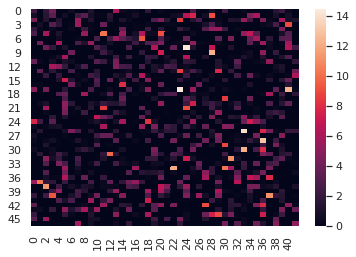

In [380]:
unit=4

f = fr_maps[unit]
sns.heatmap(m)


### test implementation

In [34]:
spatial_funcs = reload(spatial_funcs)
rs = reload(rs)

a,b,c = spatial_funcs.get_border_score(of_dat.x, of_dat.y, fr, fr_maps, track_params.x_cm_lims, track_params.y_cm_lims, track_params.cm_bin, track_params.sig_alpha, track_params.n_perm,
                     border_fr_thr=track_params.border_fr_thr, min_field_size_bins=track_params.border_min_field_size_bins, border_width_bins=track_params.border_width_bins, non_linear=True)

In [48]:
b[:,0]

(32,)

In [57]:
import statsmodels.api as sm
b2 = np.array(b)
b2[:,1:] = np.abs(b2[:,1:])
m=sm.OLS(a['score'],sm.add_constant(b2)).fit()
print(m.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.317   
Dependent Variable: score            AIC:                -12.7658
Date:               2020-08-26 14:37 BIC:                -5.4371 
No. Observations:   32               Log-Likelihood:     11.383  
Df Model:           4                F-statistic:        4.604   
Df Residuals:       27               Prob (F-statistic): 0.00578 
R-squared:          0.406            Scale:              0.034068
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const      0.3102     0.0521    5.9525   0.0000    0.2033    0.4171
x1         0.0182     0.0052    3.5154   0.0016    0.0076    0.0288
x2        -0.0200     0.0158   -1.2673   0.2159   -0.0524    0.0124
x3         0.0250     0.0263    0.9514   0.3499   -0.0289    0.0789
x4        -0.

on this data set, the encoding model coefficients can be used to explained 31% of the border score variance. interestingly, the largest predictor of border score were the mean firing rate coefficient and the center proximity coefficient.